# im2latex(S): Data Binning

&copy; Copyright 2017 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

# What This Program Does
This notebook curates the [im2latex-100k dataset from Harvard NLP](https://zenodo.org/record/56198#.WT4fsxMrJE4) from a [Harvard NLP project](http://lstm.seas.harvard.edu/latex/) generated using [their code]( https://github.com/Miffyli/im2latex-dataset).

* This notebook loads the data set which are png files generated using [textogif](https://www.fourmilab.ch/webtools/textogif/textogif.html) (via the abovementioned sourcecode)
* Checks and visualizes the data
* Curates the data - whitening etc.
* Converts it to numpy arrays and finally stores it as pickle files.

----
## 'Binning' Training Data by Markup Sequence Length
Next, we'll group the samples by length of the (tokenized) latex formulas. The idea is to standardize the sequence lengths to a small set of fixed lengths (by padding smaller neighboring sequences with a 'null' tokens at the end.). This will allow us to create equal length batches for RNN/LSTM training while minimizing wasted training cycles. The [Show, Attend and Tell paper](https://www.semanticscholar.org/paper/Show-Attend-and-Tell-Neural-Image-Caption-Generati-Xu-Ba/146f6f6ed688c905fb6e346ad02332efd5464616) suggests this approach. At every epoch, we'll randomly/uniformly draw batches from within each group. Then we'll randomize said batch-list and use it for the training epoch. At next epoch, we'll repeat the process. The larger our group-size, that much better randomness we'll get in the training sequence. However the downside of increasing group-size is more padding of sequence-lengths resulting in wasteful  (and worse; maybe even misleading) training cycles.

-----

In [1]:
from __future__ import print_function
import os
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [64]:
pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160
data_folder = data_dir = '../data/dataset3'
image_folder = image_dir = os.path.join(data_folder,'formula_images')
raw_data_dir = os.path.join(data_folder, 'training')

In [3]:
df_pruned = pd.read_pickle(os.path.join(data_folder, 'step3', 'df_pruned.pkl'))

In [4]:
df_pruned[['width', 'word2id_len', 'height']].corr()

,width,word2id_len,height
width,1.000000,0.818274,0.224883
word2id_len,0.818274,1.000000,0.409975
height,0.224883,0.409975,1.000000


## From the above correlation table we can clearly see the impact of pruning the outlier samples from our dataset: the correlation of word2id_len went up from ~0.72 (for dff_all) to ~0.82 (for df_pruned).

In [5]:
df_pruned[['height','width']]

,height,width
0,78,738
1,94,962
2,87,291
3,35,405
4,60,521
5,102,206
7,31,282
8,80,817
9,35,296
10,75,697


In [6]:
display(df_pruned.word2id_len.quantile((.85,.90,.95,.96,.97,.98,.985,.99,1.0)))

0.850     91.0
0.900    101.0
0.950    116.0
0.960    120.0
0.970    125.0
0.980    131.0
0.985    135.0
0.990    139.0
1.000    150.0
Name: word2id_len, dtype: float64

**Below is what the sequence length distribution looks like at this point**

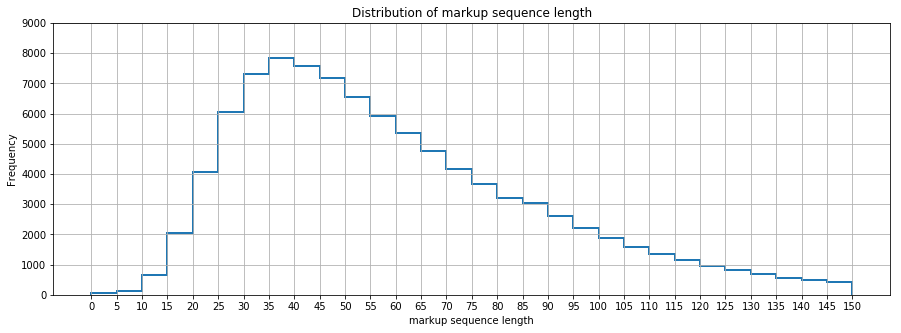

In [7]:
axes = plt.axes()
axes.set_xlabel('markup sequence length')
axes.set_title('Distribution of markup sequence length')
bins=range(0,151,5)
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=bins, xticks=bins, yticks=range(0,9001,1000))

### Data Bins
Below we create the data-bins as described at the beginning of this section.

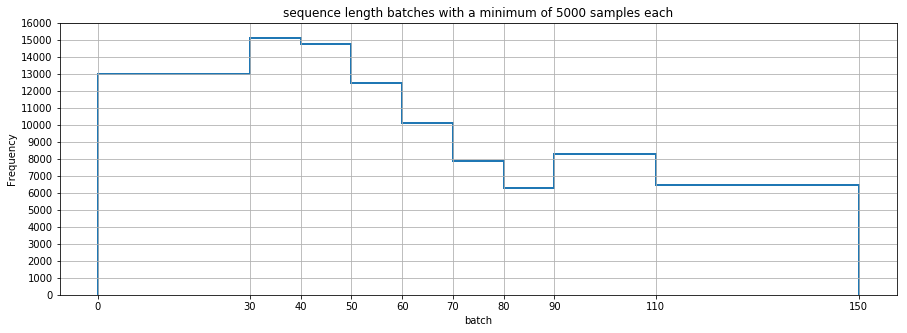

In [8]:
axes = plt.axes()
axes.set_xlabel('batch')
axes.set_ylabel('batch-count')
axes.set_title('sequence length batches with a minimum of 5000 samples each')
HYPER_bins=[0,30,40,50,60,70,80,90,110,150]
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=HYPER_bins, xticks=HYPER_bins, yticks=range(0,16001,1000))

In [10]:
## 'bin' the entries
bin_lens=np.array(HYPER_bins[1:]) + 1 #Add 1 for ensuring minimum one 'null' token at the end of sequence.
## mapper for converting pandas category# into integer bin_len (because pandas Category are special types)
m = {i:bin_lens[i] for i in range(len(bin_lens))}

cats = pd.cut(df_pruned.word2id_len, HYPER_bins, labels=False)
df_bins = df_pruned.assign(bin_len=cats.map(m))[['image', 'height', 'width', 'word2id_len', 'bin_len', 'word2id', 'latex_ascii' ]]
df_bins.head()

,image,height,width,word2id_len,bin_len,word2id,latex_ascii
0,23be72ded29e9b4_basic.png,78,738,112,151,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11...",\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ ...
1,8c904c5d9c7bd63_basic.png,94,962,129,151,"[330, 345, 323, 353, 18, 355, 29, 6, 17, 11, 353, 160, 353, 343, 328, 341, 345, 289, 355, 353, 3...",d s ^ { 2 } = ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } ...
2,1f111caa1be3516_basic.png,87,291,51,61,"[315, 161, 324, 353, 207, 353, 334, 341, 342, 332, 355, 355, 272, 283, 324, 353, 340, 30, 16, 35...",\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \...
3,76287b1b483a0d2_basic.png,35,405,43,51,"[6, 353, 125, 42, 355, 324, 353, 326, 355, 333, 7, 324, 353, 335, 336, 355, 29, 16, 10, 58, 58, ...","( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 ,"
4,7483d06c1e14dcb_basic.png,60,521,61,71,"[49, 324, 353, 345, 346, 326, 346, 355, 29, 18, 238, 277, 353, 44, 324, 353, 21, 355, 323, 353, ...",S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ( 1 ) } N _ { 5 } ^ { ( 2 ) } N _ { 5 } ^ { ( 3 ) ...


In [11]:
df_bins

,image,height,width,word2id_len,bin_len,word2id,latex_ascii
0,23be72ded29e9b4_basic.png,78,738,112,151,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11...",\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ ...
1,8c904c5d9c7bd63_basic.png,94,962,129,151,"[330, 345, 323, 353, 18, 355, 29, 6, 17, 11, 353, 160, 353, 343, 328, 341, 345, 289, 355, 353, 3...",d s ^ { 2 } = ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } ...
2,1f111caa1be3516_basic.png,87,291,51,61,"[315, 161, 324, 353, 207, 353, 334, 341, 342, 332, 355, 355, 272, 283, 324, 353, 340, 30, 16, 35...",\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \...
3,76287b1b483a0d2_basic.png,35,405,43,51,"[6, 353, 125, 42, 355, 324, 353, 326, 355, 333, 7, 324, 353, 335, 336, 355, 29, 16, 10, 58, 58, ...","( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 ,"
4,7483d06c1e14dcb_basic.png,60,521,61,71,"[49, 324, 353, 345, 346, 326, 346, 355, 29, 18, 238, 277, 353, 44, 324, 353, 21, 355, 323, 353, ...",S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ( 1 ) } N _ { 5 } ^ { ( 2 ) } N _ { 5 } ^ { ( 3 ) ...
5,8135cab7e6b93ae_basic.png,102,206,34,41,"[165, 353, 44, 355, 324, 353, 19, 355, 29, 283, 276, 332, 324, 353, 336, 29, 17, 355, 326, 324, ...","\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a _ { j } \sp { \dagger } a _ { j } \, ."
7,2278ffa4860ed9b_basic.png,31,282,28,31,"[61, 323, 353, 8, 355, 330, 61, 323, 353, 8, 355, 38, 29, 177, 61, 323, 353, 8, 355, 330, 237, 2...","\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } d \phi = J _ { B } ."
8,1d7098797009973_basic.png,80,817,114,151,"[353, 160, 353, 237, 323, 353, 240, 240, 355, 355, 353, 31, 355, 355, 9, 353, 160, 353, 17, 355,...",{ \frac { \phi ^ { \prime \prime } } { A } } + { \frac { 1 } { A } } \left( - { \frac { 1 } { 2 ...
9,f4f265238eb9724_basic.png,35,296,28,31,"[234, 324, 353, 212, 355, 6, 36, 323, 353, 212, 219, 355, 11, 331, 336, 323, 353, 212, 355, 350,...",\partial _ { \mu } ( F ^ { \mu \nu } - e j ^ { \mu } x ^ { \nu } ) = 0 .
10,ebf76c96dda24fb_basic.png,75,697,83,91,"[35, 324, 353, 31, 34, 43, 355, 29, 160, 353, 17, 355, 353, 17, 22, 238, 37, 324, 353, 17, 16, 3...",E _ { A D M } = \frac { 1 } { 1 6 \pi G _ { 1 0 } } \oint _ { \infty } d \Sigma ^ { m } \lbrace ...


In [12]:
df_bins.groupby('bin_len').count()

,image,height,width,word2id_len,word2id,latex_ascii
bin_len,,,,,,
31,14386,14386,14386,14386,14386,14386
41,15273,15273,15273,15273,15273,15273
51,14553,14553,14553,14553,14553,14553
61,12252,12252,12252,12252,12252,12252
71,9858,9858,9858,9858,9858,9858
81,7642,7642,7642,7642,7642,7642
91,6155,6155,6155,6155,6155,6155
111,8006,8006,8006,8006,8006,8006
151,6155,6155,6155,6155,6155,6155


In [14]:
HYPER_batch_size = 80
## randomly pick test-data - approx 5% of data size - ensuring it is an integral multiple of batch_size
test_count = int(df_bins.shape[0]*0.05 // HYPER_batch_size) * HYPER_batch_size
df_test = df_bins.sample(n=test_count)
df_train = df_bins.drop(df_test.index)
## round df_train down to an integral multiple of batch_size
df_train = df_train.drop(df_train.sample(n=(df_train.shape[0]%HYPER_batch_size)).index)
assert df_train.index.intersection(df_test.index).shape[0] == 0
print(df_bins.shape, df_test.shape, df_train.shape)
#df_test.to_pickle(os.path.join(data_folder,'training/df_test.pkl'))
#df_train.to_pickle(os.path.join(data_folder,'training/df_train.pkl'))

(94280, 7) (4640, 7) (89600, 7)


In [15]:
df_train.index.size

89600

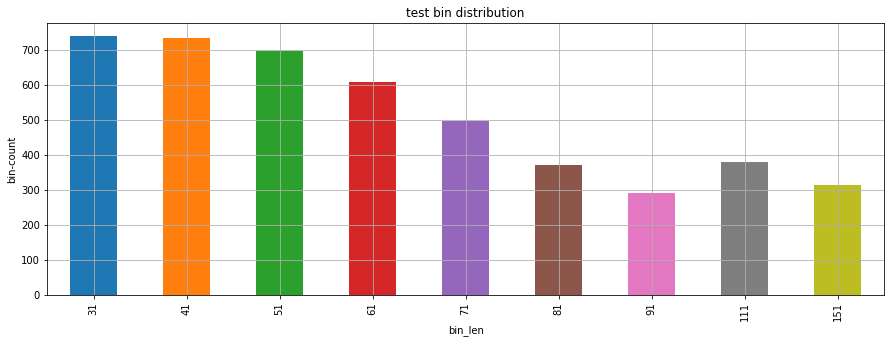

In [16]:
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('test bin distribution')
df_test.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

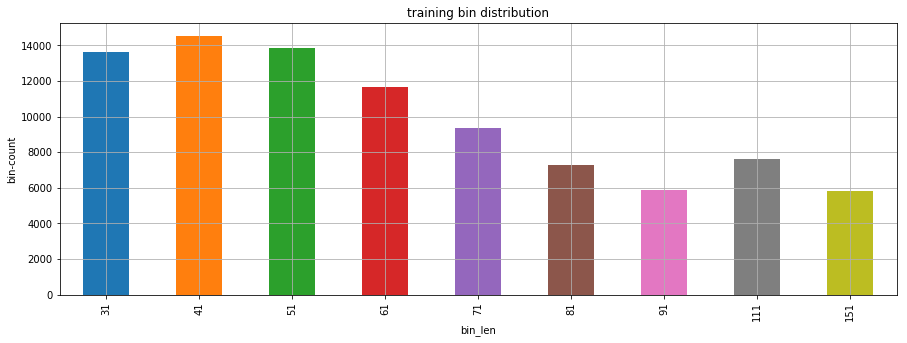

In [17]:
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('training bin distribution')
df_train.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

In [24]:
## Code that adjusts bin-composition in order to minimze waste of samples owing to batch quantization
def print_bin_waste(df_, batch_size_):
    cum = 0
    bin_lens = sorted(df_.bin_len.unique().tolist())
    counts = [df_[df_.bin_len==l].shape[0] for l in bin_lens]
    total = sum(counts)
    print('bin_len|count|waste|cumulative')
    for i in range(len(bin_lens)):
        rem = counts[i] % batch_size_
        cum += rem
        print("%d)\t%d,\t%d,\t%d"%(bin_lens[i], counts[i], rem, cum))
    assert total == sum(counts)
    print('total %% batch_size_ = %d'%(total%batch_size_,))
    return

def adjust_bins(df_bins_, batch_size_):
    df_ = df_bins_.copy()
    bins = sorted(df_.bin_len.unique().tolist())
    for i in range(len(bins)-1):
        ## Can't use bin_count here because it changes during the loop
        rem = df_[df_.bin_len == bins[i]].shape[0] % batch_size_
        if rem > 0:
            ## Move the tail of the bin into the next one
            idx_tail = df_[df_.bin_len == bins[i]].word2id_len.sort_values()[-1*rem:].index
            df_.loc[idx_tail, 'bin_len'] = bins[i+1]
            print('Moving %d samples from bin %d to %d'%(rem,bin_lens[i],bin_lens[i+1]))

    return df_

# def adjust_bins2(df_bins_, batch_size_):
#     df_ = df_bins_.copy()
#     ## Idea is to spread the sample-waste over all the bins, proportional to the size of the bin.
#     waste = df_.shape[0] % batch_size_
#     bin_lens = sorted(df_.bin_len.unique().tolist())
#     bin_counts = [df_[df_.bin_len==l].shape[0] for l in bin_lens]
#     ## Draw from a multinomial distribution to get the number of samples to waste in each bin.
#     pvals = np.array(bin_counts, dtype=float) / df_.shape[0]
#     assert sum(pvals) == 1.0
#     print(pvals, " sum=%f"%(sum(pvals),))
#     bin_waste = np.random.multinomial(waste, pvals)
#     print(bin_waste, " sum=%d"%(sum(bin_waste),))
#     ## Now adjust the bins
#     for i in range(len(bin_lens)-1):
#         ## Can't use bin_count here because it changes during the loop
#         rem = df_[df_.bin_len == bin_lens[i]].shape[0] % batch_size_ - bin_waste[i]
#         if rem > 0:
#             ## Move the tail of the bin into the next one
#             df_slice = df_[df_.bin_len == bin_lens[i]].word2id_len.sort_values()[-1*rem:].index
#             df_.loc[df_slice, 'bin_len'] = bin_lens[i+1]
#             print('Moving %d samples from bin %d to %d'%(rem,bin_lens[i],bin_lens[i+1]))
#         elif rem < 0:
#             ## Move in the head of the next bin into this one
#             df_slice = df_[df_.bin_len == bin_lens[i+1]].word2id_len.sort_values()[:-1*rem].index
#             new_bin_len = df_.loc[df_slice].word2id_len.max() + 1
#             print('Moving %d samples from bin %d to %d (old_bin_len = %d)'%(rem,bin_lens[i+1],new_bin_len,bin_lens[i]))
#             df_.loc[df_slice, 'bin_len'] = new_bin_len
#             df_.loc[df_.bin_len == bin_lens[i], 'bin_len'] = new_bin_len
#             bin_lens[i] = new_bin_len
#     print('Final bins: ', bin_lens)
#     return df_

bin_len|count|waste|cumulative
31)	13638,	38,	38
41)	14528,	48,	86
51)	13846,	6,	92
61)	11638,	38,	130
71)	9356,	76,	206
81)	7270,	70,	276
91)	5859,	19,	295
111)	7624,	24,	319
151)	5841,	1,	320
total % batch_size_ = 0
Moving 38 samples from bin 31 to 41
Moving 6 samples from bin 41 to 51
Moving 12 samples from bin 51 to 61
Moving 50 samples from bin 61 to 71
Moving 46 samples from bin 71 to 81
Moving 36 samples from bin 81 to 91
Moving 55 samples from bin 91 to 111
Moving 79 samples from bin 111 to 151
bin_len|count|waste|cumulative
31)	13600,	0,	0
41)	14560,	0,	0
51)	13840,	0,	0
61)	11600,	0,	0
71)	9360,	0,	0
81)	7280,	0,	0
91)	5840,	0,	0
111)	7600,	0,	0
151)	5920,	0,	0
total % batch_size_ = 0


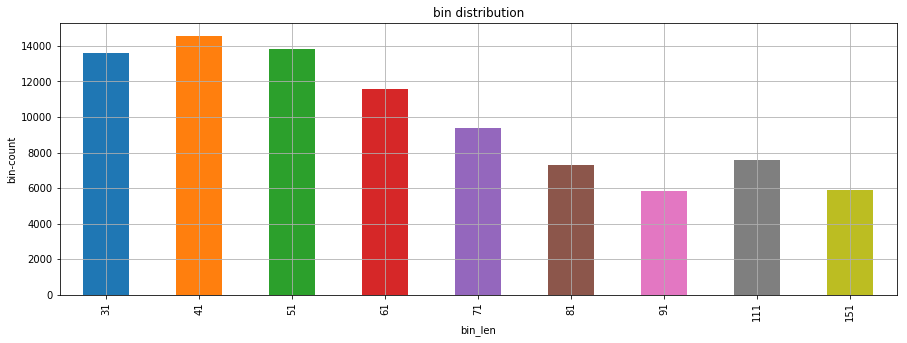

In [25]:
print_bin_waste(df_train, HYPER_batch_size)
df_train_adjusted = adjust_bins(df_train, HYPER_batch_size)
print_bin_waste(df_train_adjusted, HYPER_batch_size)
## Plot
axes = plt.axes()
axes.set_xlabel('bin_len')
axes.set_ylabel('bin-count')
axes.set_title('bin distribution')
df_train_adjusted.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

bin_len|count|waste|cumulative
31)	741,	21,	21
41)	735,	15,	36
51)	699,	59,	95
61)	609,	49,	144
71)	498,	18,	162
81)	371,	51,	213
91)	292,	52,	265
111)	381,	61,	326
151)	314,	74,	400
total % batch_size_ = 0
Moving 21 samples from bin 31 to 41
Moving 36 samples from bin 41 to 51
Moving 15 samples from bin 51 to 61
Moving 64 samples from bin 61 to 71
Moving 2 samples from bin 71 to 81
Moving 53 samples from bin 81 to 91
Moving 25 samples from bin 91 to 111
Moving 6 samples from bin 111 to 151
bin_len|count|waste|cumulative
31)	720,	0,	0
41)	720,	0,	0
51)	720,	0,	0
61)	560,	0,	0
71)	560,	0,	0
81)	320,	0,	0
91)	320,	0,	0
111)	400,	0,	0
151)	320,	0,	0
total % batch_size_ = 0


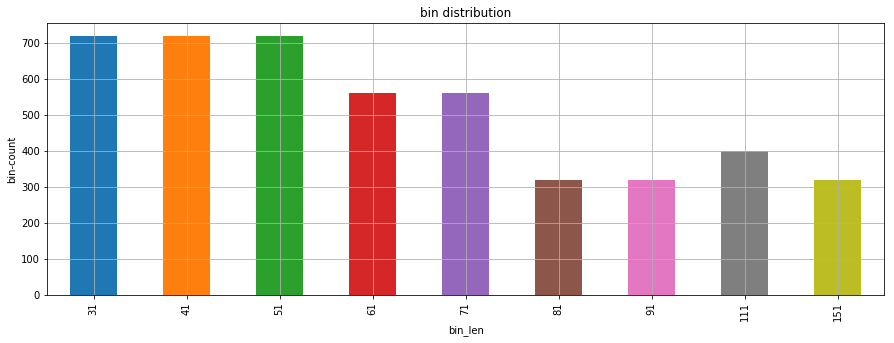

In [30]:
print_bin_waste(df_test, HYPER_batch_size)
df_test_adjusted = adjust_bins(df_test, HYPER_batch_size)
print_bin_waste(df_test_adjusted, HYPER_batch_size)
## Plot
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('bin distribution')
df_test_adjusted.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

In [31]:
#df_train_adjusted.to_pickle(os.path.join(data_folder, 'training/df_train_adjusted.pkl'))
#df_test_adjusted.to_pickle(os.path.join(data_folder, 'training/df_test_adjusted.pkl'))

In [46]:
def get_padded(df_):
    def pad(row_ar):
        """
        Return null-terminated and padded token-sequence, padded upto bin_len size.
        Arguments:
            row_ar: sequence ('bin_len', 'word2id_len', 'word2id')
        """
        word2id = row_ar[2]
        ## plen = (pad_before, pad_after)
        plen = (0, row_ar[0]-row_ar[1])
        ## Ensure that we have room for at least one null-terminator
        assert plen[1] > 0
        return np.pad(word2id, plen, 'constant', constant_values=0).tolist()
    
    df = df_[['bin_len', 'word2id_len', 'word2id']]
    padded_seq = df.apply(pad, raw=True, reduce=True, axis=1)
    df_padded = df_.assign(seq_len=df_.word2id_len+1, ## add 1 for <eos> token (null)
                      padded_seq=padded_seq, 
                      padded_seq_len=padded_seq.str.len())
    print(df_padded.shape)
    display(df_padded[:1])
    return df_padded

In [47]:
def get_squashed(df_):
    def squash(row_ar):
        """
        Return padded token-sequence, with all spaces removed and padded upto bin_len size.
        Arguments:
            row_ar: sequence ('bin_len', 'word2id')
        """
        word2id = np.asarray(row_ar[1])
        squashed = word2id[word2id != 556]
        return squashed.tolist()
    def pad2(row_ar):
        """
        Return null-terminated and padded token-sequence, padded upto bin_len size.
        Arguments:
            row_ar: sequence ('bin_len', 'col')
        """
        lst = row_ar[1]
        ## plen = (pad_before, pad_after)
        plen = (0, row_ar[0] - len(lst))
        ## Ensure that we have room for at least one null-terminator
        try:
            assert plen[1] > 0
        except:
            print (row_ar)
            raise
        return np.pad(lst, plen, 'constant', constant_values=0).tolist()

    df = df_[['bin_len', 'word2id']]
    squashed_seq = df.apply(squash, raw=True, reduce=True, axis=1)
    df_ =  df_.assign(squashed_seq=squashed_seq,
                      squashed_len=squashed_seq.str.len()+1) ## add 1 for <eos>/null token
    ## Pad the squashed sequence. Had to do this separately since str.len() would
    ## return bin-lens if this was done in the previous step.
    df = df_[['bin_len', 'squashed_seq']]
    padded_seq = df.apply(pad2, raw=True, reduce=True, axis=1)
    df_squashed = df_.assign(squashed_seq=padded_seq)
    print(df_squashed.shape)
    display(df_squashed[:1])
    return df_squashed

In [48]:
df_train_padded = get_padded(df_train_adjusted)
assert sum(df_train_padded.padded_seq_len != df_train_padded.bin_len) == 0
assert sum(df_train_padded.word2id_len != (df_train_padded.seq_len-1)) == 0

(89600, 10)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len
0,23be72ded29e9b4_basic.png,78,738,112,151,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11...",\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ ...,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11...",151,113


In [49]:
df_train_squashed = get_squashed(df_train_padded)
assert sum(df_train_squashed.seq_len < df_train_squashed.squashed_len) == 0

(89600, 12)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len,squashed_len,squashed_seq
0,23be72ded29e9b4_basic.png,78,738,112,151,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11...",\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ ...,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11...",151,113,113,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11..."


In [50]:
df_test_padded = get_padded(df_test_adjusted)
assert sum(df_test_padded.padded_seq_len != df_test_padded.bin_len) == 0
assert sum(df_test_padded.word2id_len != (df_test_padded.seq_len-1)) == 0

(4640, 10)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len
92608,1aceeb2b47374c0_basic.png,45,713,113,151,"[331, 323, 353, 11, 326, 323, 353, 137, 355, 317, 355, 356, 326, 324, 353, 17, 355, 356, 331, 32...",e ^ { - a ^ { \dag } \xi } ~ a _ { 1 } ~ e ^ { a ^ { \dag } \xi } = e ^ { - a _ { 1 } ^ { \dag }...,"[331, 323, 353, 11, 326, 323, 353, 137, 355, 317, 355, 356, 326, 324, 353, 17, 355, 356, 331, 32...",151,114


In [51]:
df_test_squashed = get_squashed(df_test_padded)
assert sum(df_test_squashed.seq_len < df_test_squashed.squashed_len) == 0

(4640, 12)


,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len,squashed_len,squashed_seq
92608,1aceeb2b47374c0_basic.png,45,713,113,151,"[331, 323, 353, 11, 326, 323, 353, 137, 355, 317, 355, 356, 326, 324, 353, 17, 355, 356, 331, 32...",e ^ { - a ^ { \dag } \xi } ~ a _ { 1 } ~ e ^ { a ^ { \dag } \xi } = e ^ { - a _ { 1 } ^ { \dag }...,"[331, 323, 353, 11, 326, 323, 353, 137, 355, 317, 355, 356, 326, 324, 353, 17, 355, 356, 331, 32...",151,114,114,"[331, 323, 353, 11, 326, 323, 353, 137, 355, 317, 355, 356, 326, 324, 353, 17, 355, 356, 331, 32..."


In [53]:
df_train_squashed.seq_len[df_train_padded.bin_len == 31].values.shape
## (6144,)

(13600,)

In [54]:
df_train_squashed[df_train_squashed.bin_len == 41][['bin_len','seq_len','squashed_len']]

,bin_len,seq_len,squashed_len
5,41,35,35
17,41,37,37
20,41,38,38
27,41,33,33
40,41,32,32
42,41,37,37
44,41,34,34
51,41,39,39
59,41,37,37
75,41,38,38


In [55]:
## Since we do not have a whitespace token the squashed and sequence lengths should be the same
assert df_train_squashed.seq_len.equals(df_train_squashed.squashed_len)
assert df_test_squashed.seq_len.equals(df_test_squashed.squashed_len)

In [56]:
def make_seq_bins(df_):
    """
    Creates ndarrays of (padded) sequence bins from df_train_padded 
    and pickles them as a dictionary of ndarrays wrapped in dataframes.
    This preprocessing is needed in order to quickly obtain an ndarray of
    token-sequences at training time.
    """
    bin_lens = df_.bin_len.unique()
    bins = {}
    bins_squashed = {}
    
    for len_ in bin_lens:
        df_slice = df_[df_.padded_seq_len == len_]
        bin_ = np.array(df_slice.padded_seq.values.tolist(), dtype=np.int32)
        bin_squashed = np.array(df_slice.squashed_seq.values.tolist(), dtype=np.int32)
        assert bin_.shape[1] == len_
        assert bin_.shape[0] == df_slice.shape[0]
        bins[len_] = pd.DataFrame(bin_, index=df_slice.index)
        bins_squashed[len_] = pd.DataFrame(bin_squashed, index=df_slice.index)
    return bins, bins_squashed

In [57]:
bins_train, bins_sq_train = make_seq_bins(df_train_squashed)
bins_test, bins_sq_test = make_seq_bins(df_test_squashed)

In [58]:
def check(bins, ser):
    ## spot-check that the two file contents match.
    for bin_ in bins.keys():
        for loc_ in bins[bin_].index.values:
            ## print ('spot-checking bin %d and loc %d'%(bin_,loc_))
            try:
                assert sum(bins[bin_].loc[loc_].values != ser[loc_]) == 0
            except:
                print('Assertion failed at bin %d and loc %d'%(bin_,loc_))
                raise

In [59]:
check(bins_train, df_train_squashed.padded_seq)
check(bins_sq_train, df_train_squashed.squashed_seq)
print("all good !")

all good


### Persist to Disk

In [60]:
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)
with open(os.path.join(raw_data_dir, 'batch_size.pkl'), 'wb') as f:
  pickle.dump(HYPER_batch_size, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(raw_data_dir, 'batch_size.pkl'), 'rb') as f:
    assert pickle.load(f) == HYPER_batch_size

In [62]:
df_train_squashed.to_pickle(os.path.join(raw_data_dir, 'df_train.pkl'))
df_test_squashed.to_pickle(os.path.join(raw_data_dir, 'df_test.pkl'))

In [61]:
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)
with open(os.path.join(raw_data_dir, 'raw_seq_train.pkl'), 'wb') as f:
  pickle.dump(bins_train, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(raw_data_dir, 'raw_seq_sq_train.pkl'), 'wb') as f:
  pickle.dump(bins_sq_train, f, pickle.HIGHEST_PROTOCOL)

## Persist to disk
with open(os.path.join(raw_data_dir, 'raw_seq_test.pkl'), 'wb') as f:
  pickle.dump(bins_test, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(raw_data_dir, 'raw_seq_sq_test.pkl'), 'wb') as f:
  pickle.dump(bins_sq_test, f, pickle.HIGHEST_PROTOCOL)

In [82]:
data_props = {}
dict_vocab = pd.read_pickle(os.path.join(data_dir, 'step2', 'dict_vocab.pkl'))
word2id = dict_vocab['id']
id2word = pd.read_pickle(os.path.join(data_dir, 'step2', 'dict_id2word.pkl'))
data_props['id2word'] = id2word
data_props['word2id'] = word2id
data_props['K'] = max(id2word.keys()) + 1
data_props['SpaceTokenID'] = word2id[' '] if ' ' in word2id else None
data_props['NullTokenID'] = word2id[r'\eos']
data_props['StartTokenID'] = word2id[r'\bos']
data_props['MaxSeqLen'] = df_train_squashed.padded_seq_len.max()
padded_image_dim = pd.read_pickle(os.path.join(data_dir, 'step3', 'padded_image_dim.pkl'))
data_props['padded_image_dim'] = {'height': padded_image_dim['height'], 'width':padded_image_dim['width']}
with open(os.path.join(raw_data_dir, 'data_props.pkl'), 'wb') as f:
    pickle.dump(data_props, f, pickle.HIGHEST_PROTOCOL)

In [88]:
data_props['NullTokenID']

0

# END

In [72]:
pd.read_pickle(os.path.join('../data/generated2', 'dict_id2word.pkl'))

{0: '\\eos',
 1: '\\bos',
 2: '~',
 3: '!',
 4: '"',
 5: '#',
 6: '$',
 7: '&',
 8: "'",
 9: '(',
 10: ')',
 11: '*',
 12: '+',
 13: ',',
 14: '-',
 15: '.',
 16: '/',
 17: '0',
 18: '1',
 19: '2',
 20: '3',
 21: '4',
 22: '5',
 23: '6',
 24: '7',
 25: '8',
 26: '9',
 27: ':',
 28: ';',
 29: '<',
 30: '=',
 31: '>',
 32: '?',
 33: '@',
 34: 'A',
 35: 'B',
 36: 'C',
 37: 'D',
 38: 'E',
 39: 'F',
 40: 'G',
 41: 'H',
 42: 'I',
 43: 'J',
 44: 'K',
 45: 'L',
 46: 'M',
 47: 'N',
 48: 'O',
 49: 'P',
 50: 'Q',
 51: 'R',
 52: 'S',
 53: 'T',
 54: 'U',
 55: 'V',
 56: 'W',
 57: 'X',
 58: 'Y',
 59: 'Z',
 60: '[',
 61: '\\',
 62: '\\AA',
 63: '\\Big',
 64: '\\Bigg',
 65: '\\Biggl',
 66: '\\Biggm',
 67: '\\Biggr',
 68: '\\Bigl',
 69: '\\Bigm',
 70: '\\Bigr',
 71: '\\C',
 72: '\\Delta',
 73: '\\Downarrow',
 74: '\\Flows',
 75: '\\Gamma',
 76: '\\Huge',
 77: '\\Im',
 78: '\\J',
 79: '\\L',
 80: '\\LARGE',
 81: '\\Lambda',
 82: '\\Large',
 83: '\\Leftrightarrow',
 84: '\\Longleftarrow',
 85: '\\Longleft